In [96]:
import numpy as np
import pandas as pd
import math
import random
from matplotlib.colors import ListedColormap
from scipy.spatial.distance import euclidean, cityblock, correlation, chebyshev, cosine
import matplotlib.pyplot as plt
from IPython.display import display, HTML
from itertools import product

In [97]:
data = pd.read_table('chips.txt', header=None, sep = ',')
classes = data[2]
features = data.drop(data.columns[[2]], axis=1)
data.head()

,0,1,2
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [98]:
gauss_K = lambda r : np.exp(-2 * r ** 2)
square_K = lambda r : 0 if r > 1 else (1 - r ** 2)
triangle_K = lambda r : 0 if r > 1 else (1 - np.abs(r))

In [99]:
def get_f1_score(y_true, y_pred):
    combined = [ [a,b] for (a,b) in zip(y_true, y_pred) ]
    tp = sum(x[0] == 1 and x[1] == 1 for x in combined) 
    tn = sum(x[0] == 0 and x[1] == 0 for x in combined) 
    fp = sum(x[0] == 0 and x[1] == 1 for x in combined) 
    fn = sum(x[0] == 1 and x[1] == 0 for x in combined) 
    if tp == 0:
        return 0
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    return 2 * (precision * recall) / (precision + recall)

In [100]:
def getCrossValidationIndexes(length, k):
    indexes = []
    for i in range(0, length):
        indexes.append(i)
    random.shuffle(indexes)
    result = []
    packSize = math.ceil(length/k)
    for i in range (0, k):
        left = []
        right = []
        for j in range (i * packSize, min((i + 1) * (packSize) - 1, length)):
            right.append(indexes[j])
        for j in range (0, i * packSize):
            left.append(indexes[j])
        for j in range (min((i + 1) * (packSize) - 1, length), length):
            left.append(indexes[j])
        result.append([left, right])
    return result

In [101]:
def kNN(k, metrics, trainX, trainY, testX, K=None):
    result = []
    i = 0
    for point in testX:
        distances = [[trainY[i], metrics(point, trainX[i])] for i in range (0, len(trainY))]
        distances.sort(key=lambda p:p[1])

        stat = [0., 0.]
        if K is None:
            for d in distances[0 : k]:
                stat[int(d[0])] += 1
        else:
            w = lambda d : K(d / distances[k+1][1])
            for d in distances:
                stat[int(d[0])] += w(d[1])
            
        prediction = -1
        if (stat[0] > stat[1]):
            prediction = 0
        else:
            prediction = 1
        result.append(prediction)
    return result

In [102]:
def showVariant(data, metrics, folds, neighbours, K = None, show_plot = False):
    kf = getCrossValidationIndexes(len(data), folds)
    
    f1_score = []
    j = 0
    
    all_points = np.zeros(200)
    for train_index, test_index in kf:
        j += 1
        dataN = data.as_matrix()
        n = len(dataN[0])
        features = np.delete(dataN, n-1, 1)
        trainX = [features[i] for i in train_index]
        trainY = [dataN[i][n-1] for i in train_index]
        testX  = [features[i] for i in test_index]
        testY  = [dataN[i][n-1] for i in test_index]
        predicted = kNN(neighbours, metrics, trainX, trainY, testX, K)
        f1_cur = get_f1_score(testY, predicted) 
        f1_score.append(f1_cur)
        print(j, "fold, f1 score is", f1_cur)
        
        if show_plot:
            space = [[], []]
            space[0] = np.linspace(-1.5, 1.5, num=50)
            space[1] = np.linspace(-1.5, 1.5, num=50)
            space = np.array(list(product(*space)))
            pre = kNN(neighbours, metrics, trainX, trainY, space, K)
            
            ones = [[], []]
            zeros = [[], []]
            for pos in range(0, len(space)):
                if (pre[pos] == 1):
                    ones[0].append(space[pos][0])
                    ones[1].append(space[pos][1])
                else:
                    zeros[0].append(space[pos][0])
                    zeros[1].append(space[pos][1])
            
            plt.plot(ones[:][0], ones[:][1], "ro", markersize=1)
            plt.plot(zeros[:][0], zeros[:][1], "bo", markersize=1)
                    
            for pos in range(0, len(testY)):
                if (testY[pos] == predicted[pos]):
                    if (testY[pos] == 0):
                        plt.plot(testX[pos][0], testX[pos][1], "b^")
                    else:
                        plt.plot(testX[pos][0], testX[pos][1], "gs")
                else:
                    plt.plot(testX[pos][0], testX[pos][1], "ro")
            plt.show()
    return f1_score

In [103]:
print("No Kernel")
f1_score = showVariant(data, cityblock, 7, 7)
print("Average f1 score", np.mean(f1_score))

print("Gauss kernel")
f1_score = showVariant(data, cityblock, 7, 7, K = gauss_K)
print("Average f1 score", np.mean(f1_score))

print("Square kernel")
f1_score = showVariant(data, cityblock, 7, 7, K = square_K)
print("Average f1 score", np.mean(f1_score))

print("Triangle kernel")
f1_score = showVariant(data, cityblock, 7, 7, K = triangle_K)
print("Average f1 score", np.mean(f1_score))

No Kernel
1 fold, f1 score is 0.782608695652
2 fold, f1 score is 0.666666666667
3 fold, f1 score is 0.615384615385
4 fold, f1 score is 0.666666666667
5 fold, f1 score is 0.705882352941
6 fold, f1 score is 0.875
7 fold, f1 score is 0.545454545455
Average f1 score 0.693951934681
Gauss kernel
1 fold, f1 score is 0.571428571429
2 fold, f1 score is 0.533333333333
3 fold, f1 score is 0.8
4 fold, f1 score is 0.631578947368
5 fold, f1 score is 0.923076923077
6 fold, f1 score is 0.7
7 fold, f1 score is 0.833333333333
Average f1 score 0.713250158363
Square kernel
1 fold, f1 score is 0.833333333333
2 fold, f1 score is 0.5
3 fold, f1 score is 0.761904761905
4 fold, f1 score is 0.933333333333
5 fold, f1 score is 0.769230769231
6 fold, f1 score is 0.6
7 fold, f1 score is 0.736842105263
Average f1 score 0.733520614724
Triangle kernel
1 fold, f1 score is 0.666666666667
2 fold, f1 score is 0.75
3 fold, f1 score is 0.705882352941
4 fold, f1 score is 0.8
5 fold, f1 score is 0.705882352941
6 fold, f1 scor

In [104]:
def showFullDataSet(data):
    X = [[data[0][i], data[1][i]] for i in range (0, len(data[0]))]
    Y = [data[2][i] for i in range (0, len(data[0]))]
    for pos in range(0, len(Y)):
        if (Y[pos] == 0):
            plt.plot(X[pos][0], X[pos][1], "b^")
        else:
            plt.plot(X[pos][0], X[pos][1], "gs")
    plt.show()

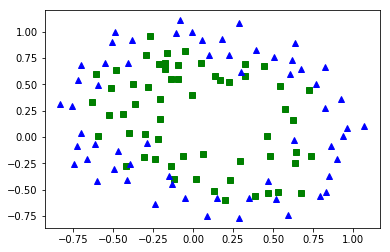

In [105]:
showFullDataSet(data)

In [106]:
def draw_plot(x, y, x_label, y_label, title):    
    x = np.array(x)
    y = np.array(y)
    plt.plot(x, y)
    
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.title(title)
    plt.grid(True)
    plt.show()

In [107]:
def kNN_stat(data, metrics, n_folds, K = None):
    kf = getCrossValidationIndexes(len(data), n_folds)
    
    f1_score = []
    k = []

    for kNN_value in range(3, 21, 2):
        f1_cur = []
        for train_index, test_index in kf:
            dataN = data.as_matrix()
            n = len(dataN[0])
            features = np.delete(dataN, n-1, 1)
            trainX = [features[i] for i in train_index]
            trainY = [dataN[i][n-1] for i in train_index]
            testX  = [features[i] for i in test_index]
            testY  = [dataN[i][n-1] for i in test_index]
            predicted = kNN(kNN_value, metrics, trainX, trainY, testX, K)
            f1_cur.append(get_f1_score(testY, predicted)) 
        f1_score.append(np.mean(f1_cur))
        k.append(kNN_value)
    return f1_score, k

In [108]:
def statistic(neighbours, f1_score, metrics):
    draw_plot(neighbours, f1_score, 'Number of neighbours', "F1 score", metrics)

[0.73606214415590787, 0.69592452365561619, 0.67479982423591456, 0.68786591559700805, 0.66879280140149699, 0.64220370422416462, 0.65094623298957655, 0.63097418454561327, 0.61143835524640466]
[3, 5, 7, 9, 11, 13, 15, 17, 19]


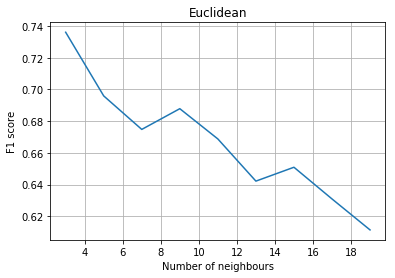

In [109]:
a1, k1 = kNN_stat(data, euclidean, 7)
print(a1)
print(k1)
statistic(k1, a1, "Euclidean")

[0.7044529933185395, 0.74454781912765111, 0.67346938775510201, 0.66467253568093909, 0.69906599003237668, 0.70143495994889193, 0.63174603174603161, 0.63307779252051688, 0.63516634724065069]
[3, 5, 7, 9, 11, 13, 15, 17, 19]


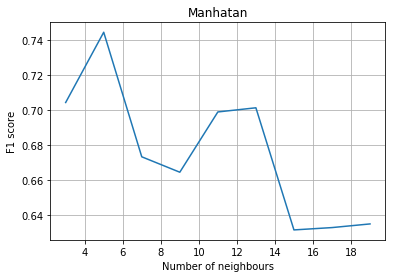

In [110]:
a2, k2 = kNN_stat(data, cityblock, 7)
print(a2)
print(k2)
statistic(k2, a2, "Manhatan")

In [111]:
# a3, k3 = kNN_stat(data, correlation, 7)
# print(a3)
# print(k3)
# statistic(k3, a3, "Сorrelation")

In [112]:
# a4, k4 = kNN_stat(data, cosine, 7)
# print(a4)
# print(k4)
# statistic(k3, a3, "Cosine")

[0.6875063115664618, 0.63148438862724565, 0.66775482122673624, 0.60992063492063486, 0.63949938949938956, 0.64402663899567913, 0.70106814655686844, 0.72955182072829139, 0.70239550365600789]
[3, 5, 7, 9, 11, 13, 15, 17, 19]


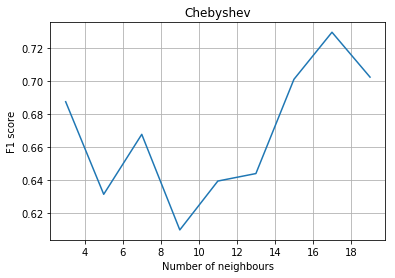

In [113]:
a5, k5 = kNN_stat(data, chebyshev, 7)
print(a5)
print(k5)
statistic(k5, a5, "Chebyshev")

In [114]:
transformations = [[lambda x: x, 'pure'] 
                  ,[lambda x: (x[0], x[1], x[0] ** 2 + x[1] ** 2),'x,y -> x, y, x**2 + y**2']
                  ,[lambda x: (x[0], x[1], x[0] * x[1], x[0] ** 2, x[1] ** 2), 'x, y -> x, y, xy, x ** 2, y ** 2']
                  ,[lambda x: (math.sqrt(x[0] ** 2 + x[1] ** 2), math.atan(x[1]/x[0])),'x,y -> sqrt(x ** 2 + y ** 2), arctan(y/x)']]

kernels = [[None, 'pure'], [square_K, 'square'], [triangle_K, 'triangle'], [gauss_K, 'gauss']]

In [115]:
def showPlot(neighbours, metrics, trainX, trainY, testX, K=None):
    space = [[], []]
    space[0] = np.linspace(-1.5, 1.5, num=50)
    space[1] = np.linspace(-1.5, 1.5, num=50)
    space = np.array(list(product(*space)))
    pre = kNN(neighbours, metrics, trainX, trainY, space, K)

    ones = [[], []]
    zeros = [[], []]
    for pos in range(0, len(space)):
        if (pre[pos] == 1):
            ones[0].append(space[pos][0])
            ones[1].append(space[pos][1])
        else:
            zeros[0].append(space[pos][0])
            zeros[1].append(space[pos][1])

    plt.plot(ones[:][0], ones[:][1], "ro", markersize=1)
    plt.plot(zeros[:][0], zeros[:][1], "bo", markersize=1)

    for pos in range(0, len(testY)):
        if (testY[pos] == predicted[pos]):
            if (testY[pos] == 0):
                plt.plot(testX[pos][0], testX[pos][1], "b^")
            else:
                plt.plot(testX[pos][0], testX[pos][1], "gs")
        else:
            plt.plot(testX[pos][0], testX[pos][1], "ro")
    plt.show()

In [116]:
def knnWithTransformation(data, metric, fold, show_plots = False):
    dataN = data.as_matrix()
    n = len(dataN[0])
    features = np.delete(dataN, n-1, 1)
    classes = np.array(data[n-1])
    classes = classes.reshape(len(classes), 1)

    result = pd.DataFrame(columns=['k', 'metric', 'kernel', 'transformation', 'f1_score'])
    for kernel in kernels:
        for transform in transformations:
            transformed_data = np.array(list(map(transform[0], features)))
            transformed_data = np.append(transformed_data, classes, 1)  
            transformed_data = pd.DataFrame(transformed_data)
            print(str(metric).split(' ')[1], transform[1])
            f1_score, k = kNN_stat(transformed_data, metric, fold, kernel[0])
            for i in range (0, len(k)):    
                cur = pd.DataFrame([[k[i], str(metric).split(' ')[1], kernel[1], transform[1], f1_score[i]]], columns=['k', 'metric', 'kernel', 'transformation', 'f1_score'])
                result = result.append(cur, ignore_index=True)
            if show_plots:
                statistic(k, f1_score, str(metric).split(' ')[1])
    result = result.sort_values(by='f1_score', ascending = 0)
    display(result.head(10))

1 fold, f1 score is 0.5


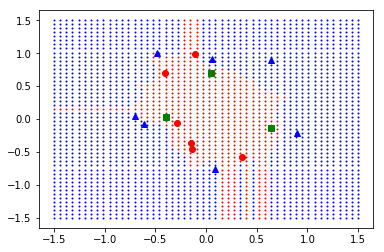

2 fold, f1 score is 0.666666666667


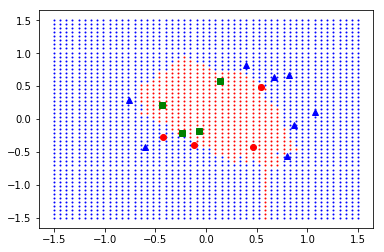

3 fold, f1 score is 0.615384615385


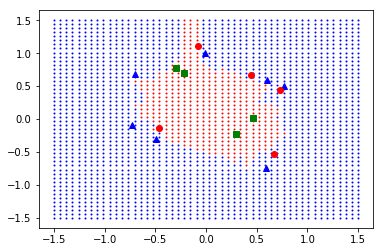

4 fold, f1 score is 0.666666666667


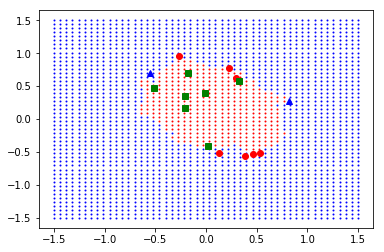

5 fold, f1 score is 0.666666666667


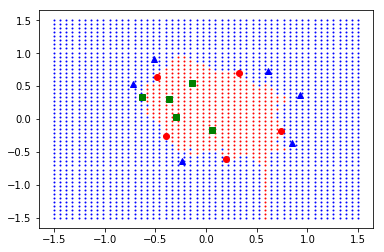

6 fold, f1 score is 0.823529411765


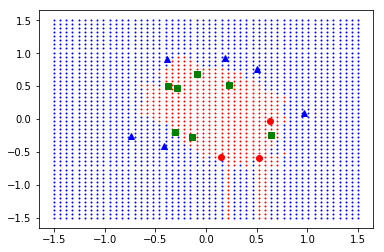

7 fold, f1 score is 0.777777777778


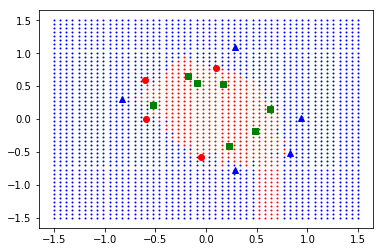

[0.5,
 0.66666666666666663,
 0.61538461538461531,
 0.66666666666666663,
 0.66666666666666674,
 0.82352941176470584,
 0.77777777777777779]

In [120]:
dataN = data.as_matrix()
n = len(dataN[0])
features = np.delete(dataN, n-1, 1)
classes = np.array(data[n-1])
classes = classes.reshape(len(classes), 1)

transformed_data = np.array(list(map(transformations[2][0], features)))
transformed_data = np.append(transformed_data, classes, 1)  
transformed_data = pd.DataFrame(transformed_data)

showVariant(data, cityblock, 7, 7, K = None, show_plot = True)

In [ ]:
knnWithTransformation(data, euclidean, fold = 7)

In [ ]:
knnWithTransformation(data, cityblock, fold = 7)

In [ ]:
# knnWithTransformation(data, correlation, fold = 7)

In [ ]:
# knnWithTransformation(data, cosine, fold = 7)

In [ ]:
knnWithTransformation(data, chebyshev, fold = 7)